<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Selected Features (FW)</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window Forecasting</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

In [4]:
# load the best features dictionaries back from the file
with open('../../data/selected_features/feature_set_01_filter_and_wrapper.json', 'r') as json_file:
    selected_features_filter_and_wrapper = json.load(json_file)

with open('../../data/selected_features/feature_set_02_embedded.json', 'r') as json_file:
    selected_features_embedded = json.load(json_file)

In [5]:
# subset the features
pts_sub_fw_features = pts_all_features[selected_features_filter_and_wrapper['TOTAL_PTS'] + ['TOTAL_PTS']]
pts_sub_e_features = pts_all_features[selected_features_embedded['TOTAL_PTS'] + ['TOTAL_PTS']]

pm_sub_fw_features = pm_all_features[selected_features_filter_and_wrapper['PLUS_MINUS'] + ['PLUS_MINUS']]
pm_sub_e_features = pm_all_features[selected_features_embedded['PLUS_MINUS'] + ['PLUS_MINUS']]

res_sub_fw_features = res_all_features[selected_features_filter_and_wrapper['GAME_RESULT'] + ['GAME_RESULT']]
res_sub_e_features = res_all_features[selected_features_embedded['GAME_RESULT'] + ['GAME_RESULT']]

In [6]:
pts_sub_fw_features.head()

,ROLL_HOME_FTM,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_PTS_PAINT,ROLL_AWAY_PTS,ROLL_HOME_PTS_FB,ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED,ROLL_AWAY_DEF_BOXOUTS,ROLL_AWAY_estimatedPace,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_DFG_PCT,ROLL_HOME_AST,ROLL_AWAY_assistToTurnover,ROLL_HOME_OPP_TOV_PCT,ROLL_HOME_estimatedDefensiveRating,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,
2021-10-23,0.805,0.808,0.50,0.577,1.000,0.60,0.208,0.443,0.391,1.000,0.612,0.291,0.840,0.298,185
2021-10-23,0.466,0.758,0.25,0.096,0.581,0.30,0.307,0.522,0.000,0.453,0.000,0.161,0.762,0.176,198
2021-10-23,0.593,0.505,0.70,0.635,0.065,0.75,0.208,0.465,0.565,0.023,0.561,0.589,0.144,0.717,239
2021-10-23,0.297,0.606,0.70,0.250,0.839,0.30,0.109,0.691,0.261,0.965,0.918,0.218,0.519,0.328,232
2021-10-24,0.254,0.202,0.70,1.000,0.548,0.45,0.455,0.646,0.348,0.732,0.765,0.393,0.591,0.002,204


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [7]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pts_sub_fw_features.drop('TOTAL_PTS', axis=1),
    pts_sub_fw_features['TOTAL_PTS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 14) (2367,) (691, 14) (691,)


In [8]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 2278.86 seconds


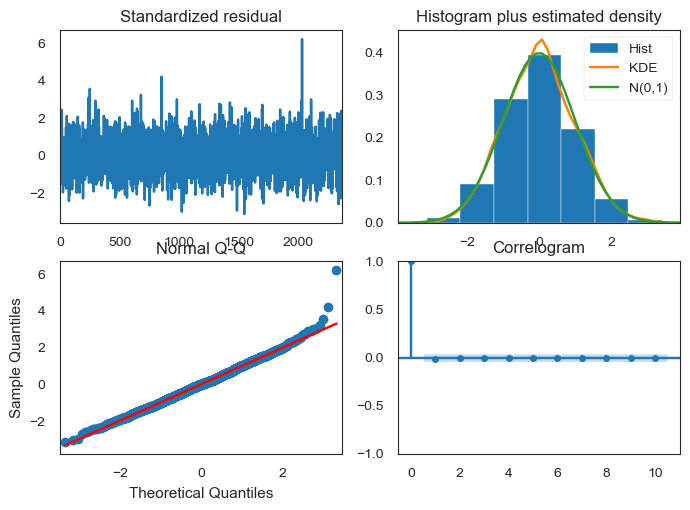

In [9]:
model1.plot_diagnostics();

In [10]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:              SARIMAX(17, 1, 1)   Log Likelihood              -10299.571
Date:                Tue, 02 Apr 2024   AIC                          20665.143
Time:                        17:10:57   BIC                          20855.518
Sample:                             0   HQIC                         20734.452
                               - 2367                                         
Covariance Type:                  opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ROLL_HOME_FTM                           2.2031      3.471      0.635      0.526      -4.601       9.007
ROLL_HOME_OPP_PTS_PAINT                 9.1383      3.059      2.988      0.003       3.143      15.134
ROLL_HOME_PTS_PAINT                     4.4890      2.865      1.567      0.117      -1.125      10.103
ROLL_AWAY_PTS                           8.5566      4.181      2.046      0.041       0.362      16.752
ROLL_HOME_PTS_FB                       10.4954      3.632      2.889      0.004       3.376      17.615
ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED     0.0467      3.437      0.014      0.989      -6.691       6.784
ROLL_AWAY_DEF_BOXOUTS                 -12.7371      4.871     -2.615      0.009     -22.284      -3.190
ROLL_AWAY_estimatedPace                23.6207      3.893      6.068      0.000      15.991      31.250
ROLL_AWAY_PTS_PAINT                    -7.2863      3.699     -1.970      0.049     -14.535      -0.037
ROLL_AWAY_DFG_PCT                       0.1065      3.264      0.033      0.974      -6.291       6.504
ROLL_HOME_AST                           3.1292      3.046      1.027      0.304      -2.841       9.099
ROLL_AWAY_assistToTurnover              8.5213      3.894      2.188      0.029       0.889      16.153
ROLL_HOME_OPP_TOV_PCT                 -10.8263      3.991     -2.713      0.007     -18.649      -3.004
ROLL_HOME_estimatedDefensiveRating     15.1567      3.367      4.502      0.000       8.558      21.755
ar.L1                                  -0.0098      0.023     -0.434      0.664      -0.054       0.034
ar.L2                                  -0.0225      0.023     -0.985      0.325      -0.067       0.022
ar.L3                                  -0.0124      0.022     -0.576      0.564      -0.055       0.030
ar.L4                                   0.0068      0.022      0.309      0.757      -0.036       0.050
ar.L5                                   0.0072      0.023      0.318      0.751      -0.037       0.052
ar.L6                                   0.0453      0.021      2.110      0.035       0.003       0.087
ar.L7                                  -0.0063      0.022     -0.285      0.776      -0.050       0.037
ar.L8                                  -0.0190      0.022     -0.860      0.390      -0.062       0.024
ar.L9                                  -0.0109      0.022     -0.488      0.626      -0.055       0.033
ar.L10                                  0.0201      0.023      0.885      0.376      -0.024       0.065
ar.L11                                 -0.0077      0.022     -0.357      0.721      -0.050       0.035
ar.L12                                 -0.0439      0.022     -1.950      0.051      -0.088       0.000
ar.L13                                 -0.0205      0.021     -0.959      0.338      -0.062       0.021
ar.L14                                  0.0156      0.022      0.725      0.468      -0.027       0.058
ar.L15           

In [11]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 6.63 %
Root Mean Squared Error: 19.2


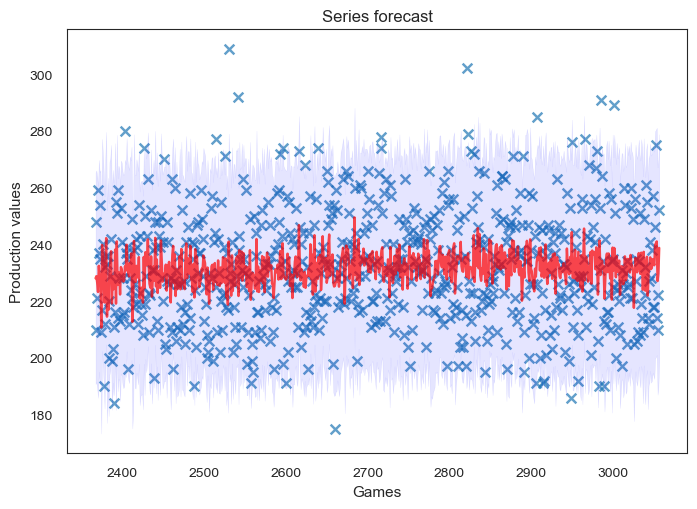

In [12]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_sub_fw_features['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [13]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pm_sub_fw_features.drop('PLUS_MINUS', axis=1),
    pm_sub_fw_features['PLUS_MINUS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 8) (2367,) (691, 8) (691,)


In [14]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 18.19 seconds


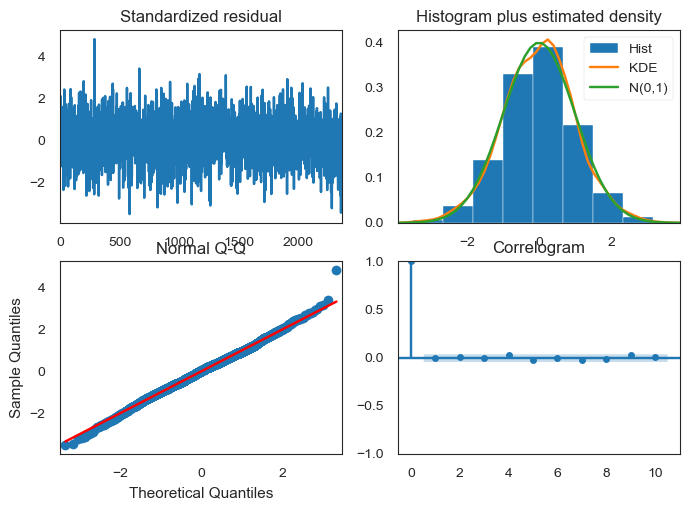

In [15]:
model1.plot_diagnostics();

In [16]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9586.668
Date:                Tue, 02 Apr 2024   AIC                          19195.336
Time:                        17:11:16   BIC                          19258.800
Sample:                             0   HQIC                         19218.441
                               - 2367                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ROLLDIFF_AWAY_STL           -3.3659      1.702     -1.977      0.048      -6.702      -0.029
ROLL_HOME_CFG_PCT            4.8282      1.825      2.645      0.008       1.250       8.406
ROLL_AWAY_OPP_PTS_PAINT      4.0879      1.952      2.095      0.036       0.263       7.913
ROLLDIFF_AWAY_PTS          -13.2524      2.551     -5.196      0.000     -18.252      -8.253
ROLLDIFF_HOME_PTS           14.3377      1.897      7.557      0.000      10.619      18.057
ROLL_HOME_SCREEN_ASSISTS     3.3425      2.650      1.261      0.207      -1.852       8.537
ROLLDIFF_AWAY_AST           -3.2716      1.994     -1.641      0.101      -7.180       0.637
ROLL_HOME_CFGA              -6.3757      1.712     -3.725      0.000      -9.731      -3.021
ar.L1                        0.8062      0.141      5.704      0.000       0.529       1.083
ma.L1                       -0.8354      0.131     -6.375      0.000      -1.092      -0.579
sigma2                     192.9500      5.198     37.118      0.000     182.762     203.138
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                14.75
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.01
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 141.37 %
Root Mean Squared Error: 14.38


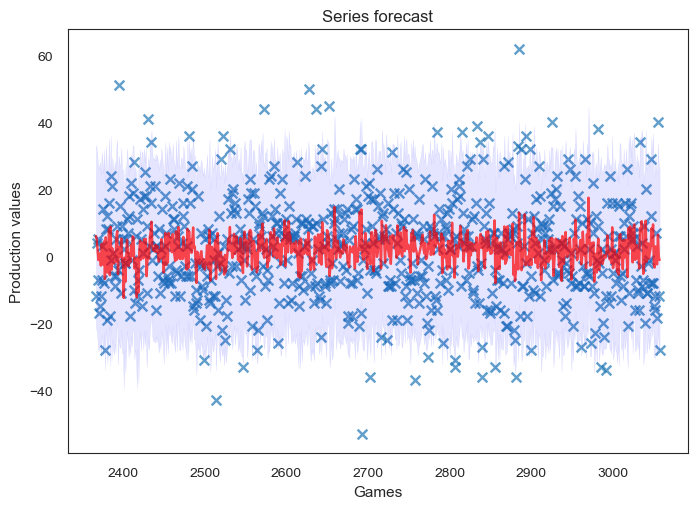

In [18]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pm_sub_fw_features['PLUS_MINUS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();